In [2]:
%load_ext autoreload
%autoreload 2

import fireplace
from fireplace.card import Card
import fireplace.cards
from hearthstone.enums import CardType

%matplotlib inline
import numpy as np
import pandas as pd

from hsdc.parallel import parallelize
import hsdc.scraper
from hsdc.scraper import get_hearthpwn_decks

import time
#from timeit import timeit

In [90]:
start = time.clock()
all_decks_df = get_hearthpwn_decks(pages = 15)
end = time.clock()
print(end-start)
all_decks_df.head()

21.003677416394567


,Deck Name,Deck Type,Class,Rating,Views,Comments,Cost,Updated,Link
0,[S19] Top 50 Legend NA Secret Paladin by Loronzo,Tempo,Paladin,49,18057,17,5700,"Nov 3, 2015 Warsong Nerf",/decks/356359-s19-top-50-legend-na-secret-paladin
1,[TwoBiers] Dreadscale Hunter by TwoBiers,Midrange,Hunter,161,66785,69,4420,"Oct 28, 2015 Warsong Nerf",/decks/354762-twobiers-dreadscale-hunter
2,[TOP 1] Legend Control Warrior (S19) by zataroHS,Control,Warrior,98,57151,126,13.8k,"Nov 2, 2015 Warsong Nerf",/decks/355100-top-1-legend-control-warrior-s19
3,[Legend] Malylock by Emixa,Control,Warlock,99,44811,60,4080,"Nov 2, 2015 Warsong Nerf",/decks/355055-legend-malylock
4,Burst Rogue 2.0 - Legend Grinder - Budget Incl...,Aggro,Rogue,390,162317,116,2900,"Nov 1, 2015 Warsong Nerf",/decks/352910-burst-rogue-2-0-legend-grinder-b...


In [91]:
decks_df = all_decks_df
decks_df = decks_df[~decks_df['Deck Type'].isin(['Theorycraft', 'Tavern Brawl', 'PvE Adventure'])]
decks_df = decks_df[decks_df['Class'].isin(['Hunter'])]
#decks_df = decks_df[decks_df['Deck Type'] == 'Midrange']
decks_df = decks_df.sort_values(by='Class')
decks_df.head()

,Deck Name,Deck Type,Class,Rating,Views,Comments,Cost,Updated,Link
1,[TwoBiers] Dreadscale Hunter by TwoBiers,Midrange,Hunter,161,66785,69,4420,"Oct 28, 2015 Warsong Nerf",/decks/354762-twobiers-dreadscale-hunter
197,Fuck traps by Gumz2732,None,Hunter,1,3,0,2580,"Nov 3, 2015 Warsong Nerf",/decks/357558-fuck-traps
198,Mid-Range Hunter by 0vie,Midrange,Hunter,1,5,0,2640,"Nov 3, 2015 Warsong Nerf",/decks/357556-mid-range-hunter
214,Traps by Grumpleloaf,None,Hunter,1,21,0,5760,"Nov 3, 2015 Warsong Nerf",/decks/357527-traps
218,Spare Parts Hunter by Surf314,Tempo,Hunter,1,22,0,4920,"Nov 3, 2015 Warsong Nerf",/decks/357521-spare-parts-hunter


In [94]:
parallel_hearthpwn = parallelize(hsdc.scraper.get_hearthpwn_deck)

start = time.clock()
#decks = list(map(hsdc.scraper.get_hearthpwn_deck, decks_df['Link']))
decks = parallel_hearthpwn(decks_df['Link'])
end = time.clock()
print(end-start)

# decks_df['Deck'] = decks
#decks_df
decks[0]
#decks


15.892178137415613


Animal Companion      2
Dr. Boom              1
Dreadscale            1
Eaglehorn Bow         2
Freezing Trap         2
Houndmaster           1
Hunter's Mark         2
Kill Command          2
King's Elekk          2
Knife Juggler         1
Loatheb               1
Mad Scientist         2
Piloted Shredder      2
Quick Shot            2
Savannah Highmane     2
Sludge Belcher        1
Snake Trap            1
Unleash the Hounds    2
Webspinner            1
dtype: int64

In [95]:
import progressbar
from hsdc.features import augment_cards

pbar = progressbar.ProgressBar(max_value=len(decks))  # Progressbar can guess max_value automatically.
augmented = [augment_cards(deck) for _, deck in pbar(enumerate(decks))]
    
features = pd.DataFrame(augmented).fillna(0)
features.head()

100% (40 of 40) |#############################| Elapsed Time: 0:00:06 Time: 6.24

CARD                                                             \
  Abusive Sergeant Acidic Swamp Ooze Acidmaw Acolyte of Pain Animal Companion   
0                0                 0       0               0                2   
1                2                 0       0               0                2   
2                0                 0       0               0                2   
3                0                 0       0               0                0   
4                0                 0       0               0                0   

                                                                         ...  \
  Annoy-o-Tron Antique Healbot Arcane Golem Arcane Shot Argent Commander ...   
0            0               0            0           0                0 ...   
1            0               0            1           0                0 ...   
2            0               0            0           0                0 ...   
3            0               0            0           0                0 ...   
4            0               0            0           2                0 ...   

  SPELL                    WEAPON        
      0  1   2  3  4  5  6      2  3  7  
0     2  0   5  6  0  0  0      0  2  0  
1     0  0   1  6  0  0  0      2  0  0  
2     1  0   5  6  0  0  0      0  2  0  
3     0  0  13  4  0  0  0      0  2  0  
4     1  2   4  0  0  0  0      0  0  0  

[5 rows x 161 columns]

In [97]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
from scipy.spatial.distance import pdist

#features = preprocessing.scale(features)
D = cosine_similarity(preprocessing.scale(features))
D

array([[ 1.        , -0.26585687,  0.39226871, ...,  0.19317755,
         0.33441711,  0.56697766],
       [-0.26585687,  1.        , -0.23069719, ..., -0.16013202,
        -0.23310934, -0.24825819],
       [ 0.39226871, -0.23069719,  1.        , ...,  0.2907823 ,
         0.2386452 ,  0.32381848],
       ..., 
       [ 0.19317755, -0.16013202,  0.2907823 , ...,  1.        ,
         0.00989372,  0.19712609],
       [ 0.33441711, -0.23310934,  0.2386452 , ...,  0.00989372,
         1.        ,  0.17349995],
       [ 0.56697766, -0.24825819,  0.32381848, ...,  0.19712609,
         0.17349995,  1.        ]])

In [98]:
pd.DataFrame(D).describe()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,...,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,0.069575,0.001300,0.092137,-0.029655,-0.056831,0.032719,-0.025246,0.043374,0.005161,-0.015302,...,-0.049864,-0.060979,0.008096,0.038576,-0.089134,0.021705,-0.050312,0.077987,0.028429,0.091733
std,0.325771,0.259580,0.320662,0.184090,0.195714,0.369812,0.187130,0.193407,0.291295,0.191472,...,0.190094,0.192972,0.181380,0.328735,0.198158,0.234411,0.190018,0.244115,0.215133,0.334412
min,-0.383960,-0.282350,-0.282579,-0.209519,-0.191974,-0.383960,-0.205217,-0.165341,-0.291514,-0.225703,...,-0.186485,-0.240715,-0.164302,-0.384504,-0.253113,-0.338680,-0.207724,-0.210054,-0.233109,-0.317807
25%,-0.172522,-0.156048,-0.200816,-0.102199,-0.150277,-0.193030,-0.109686,-0.078066,-0.212995,-0.096911,...,-0.141236,-0.178520,-0.080933,-0.166624,-0.194130,-0.130446,-0.139622,-0.096300,-0.099018,-0.175724
50%,-0.037803,-0.080541,-0.002020,-0.072653,-0.113108,-0.142379,-0.048272,0.025037,-0.081900,-0.032864,...,-0.094419,-0.065318,-0.013692,-0.110366,-0.136648,-0.000607,-0.085332,0.009895,-0.041405,-0.023391
75%,0.329334,0.078444,0.336217,-0.008920,-0.039249,0.094952,0.012955,0.112568,0.116256,0.027432,...,-0.033666,-0.017339,0.035914,0.177913,-0.056483,0.131165,-0.020394,0.194165,0.102247,0.327333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


C:\Program Files\Anaconda\envs\hs-deck-clusters\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


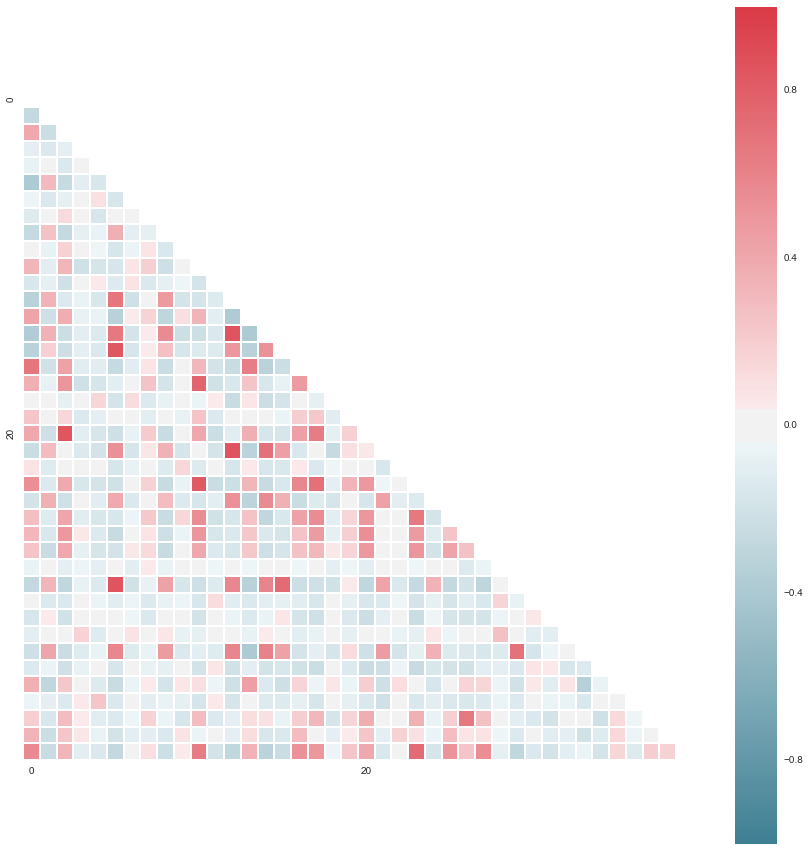

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(D, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(D, mask=mask,
            cmap=cmap, vmax=1, vmin=-1,
            annot = False,
            square = True,
            xticklabels=20, yticklabels=20,
            linewidths=.5, ax=ax)

In [102]:
# Author: Nelle Varoquaux <nelle.varoquaux@gmail.com>
# Licence: BSD

print(__doc__)
import numpy as np


from sklearn import manifold
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics.pairwise import manhattan_distances
from sklearn import preprocessing
from sklearn.decomposition import PCA

from scipy.spatial.distance import pdist
import matplotlib

matplotlib.style.use('ggplot')


mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9,
                   dissimilarity="precomputed", n_jobs=1)
#tsne = manifold.TSNE(metric='cosine', init='pca')
#pos = mds.fit_transform(2 - cosine_similarity(preprocessing.scale(features)))
#pos = mds.fit_transform(euclidean_distances(preprocessing.scale(features)) + 2)
#pos = mds.fit_transform(euclidean_distances(preprocessing.scale(features)))
#pos = mds.fit_transform(cosine_distances(preprocessing.scale(features)))
#pos = mds.fit_transform(manhattan_distances(preprocessing.scale(features)))
#print(mds.stress_)





Automatically created module for IPython interactive environment


C:\Program Files\Anaconda\envs\hs-deck-clusters\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


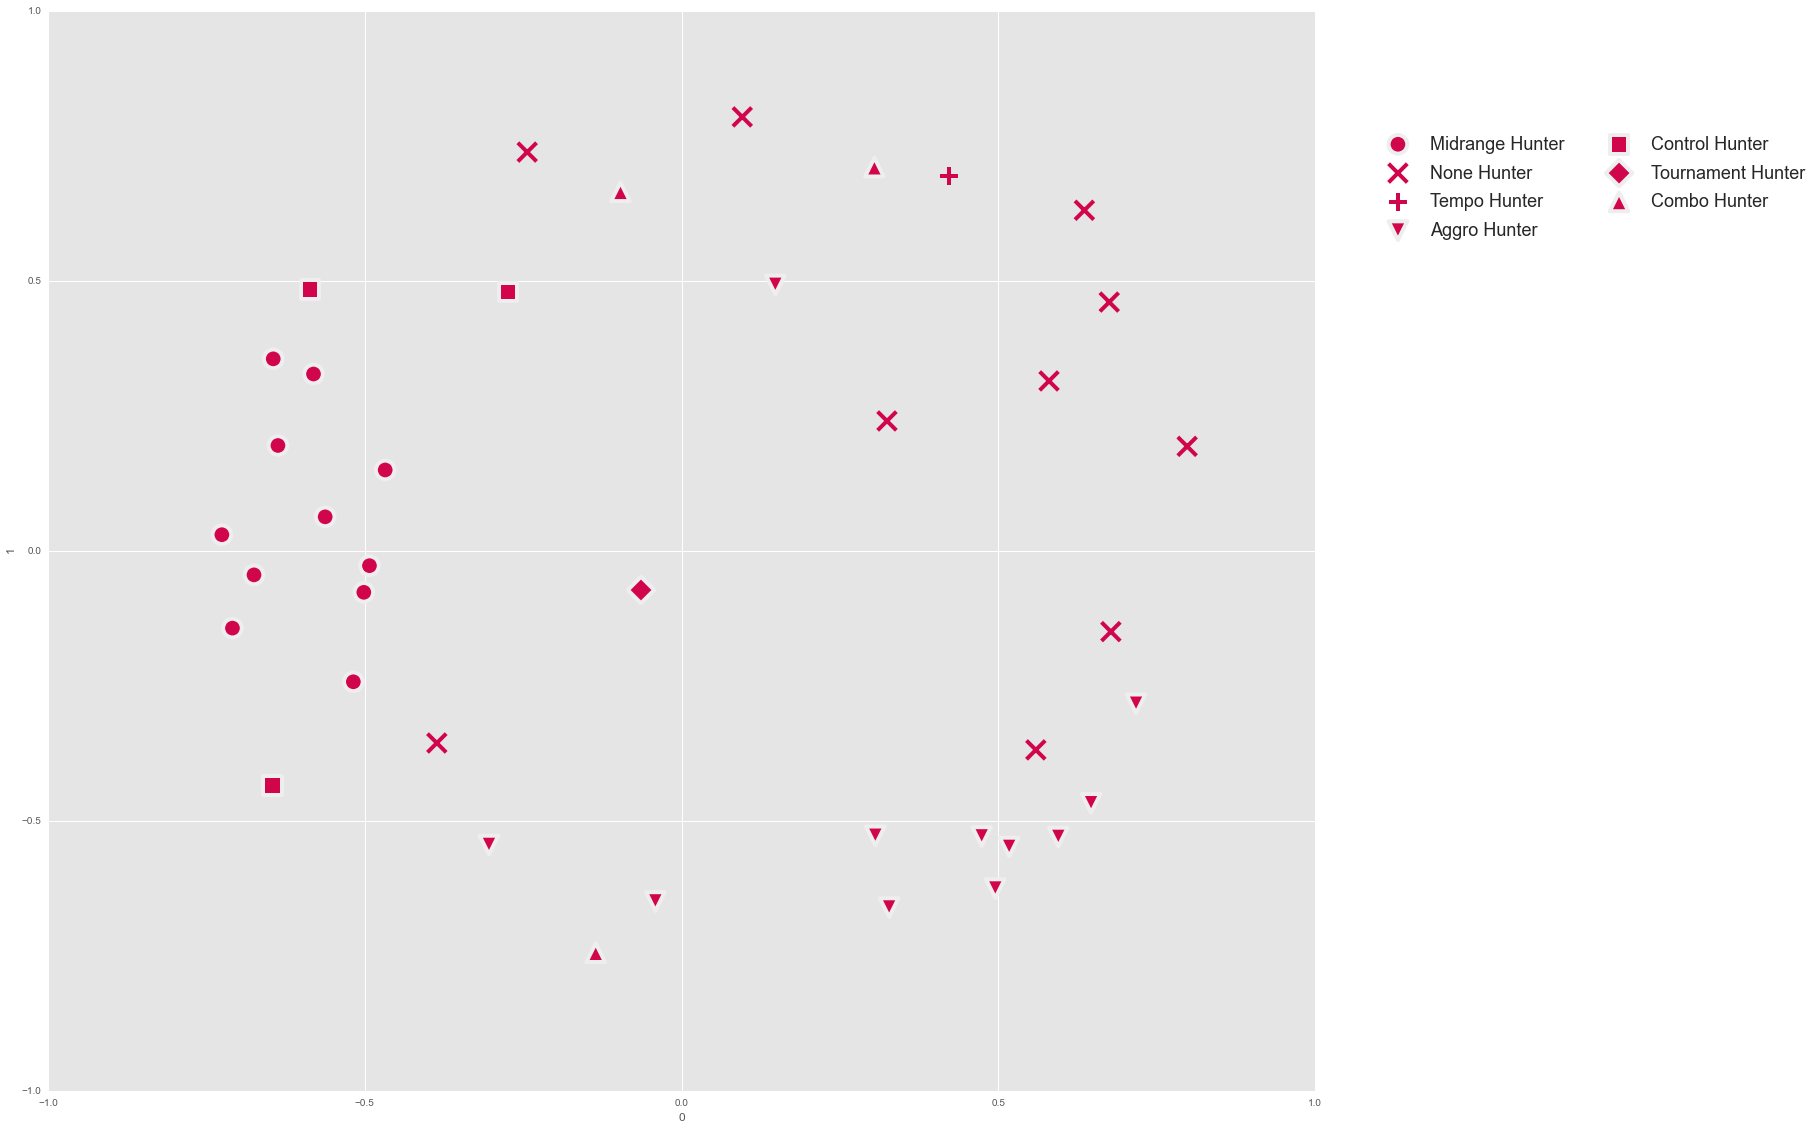

In [103]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

fig = plt.figure(1, figsize=(22, 15))
ax = plt.axes([0., 0., 1., 1.])

filled_markers = matplotlib.markers.MarkerStyle.filled_markers
filled_markers = [ 'o', 'x', '+', 'v', 's', 'D', '^' ]

pos_df = pd.DataFrame(pos)
pos_df['Label'] = decks_df.reset_index()['Deck Type'] + ' ' + decks_df.reset_index()['Class']
pos_df['Deck Type'] = decks_df.reset_index()['Deck Type']
pos_df['Class'] = decks_df.reset_index()['Class']


labels = list(pd.Series(pos_df['Label'].values.ravel()).unique())
deck_types = list(pd.Series(pos_df['Deck Type'].values.ravel()).unique())
classes = list(pd.Series(pos_df['Class'].values.ravel()).unique())
#colors = sns.color_palette("husl", len(classes))
#colors = sns.color_palette("Paired", len(classes))
colors = sns.husl_palette(len(classes), h=0.01, s=1.0, l=0.45)
#sns.palplot(colors)

for i, label in enumerate(labels):
    points = pos_df[pos_df['Label']==label]
    deck_class = points['Class'].iloc[0]
    deck_type = points['Deck Type'].iloc[0]
    marker = filled_markers[deck_types.index(deck_type)]
    
    points.plot(kind='scatter', x=0, y=1, s=350, marker=marker, linewidth=4,
                label=label, ax=ax, c=[colors[classes.index(deck_class)],] * points.shape[0]);

# Make room for the legend
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    
ax.legend(loc='best', prop={'size':18}, labelspacing=.6, bbox_to_anchor=(1.4, .9), ncol=2)
plt.show()

C:\Program Files\Anaconda\envs\hs-deck-clusters\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


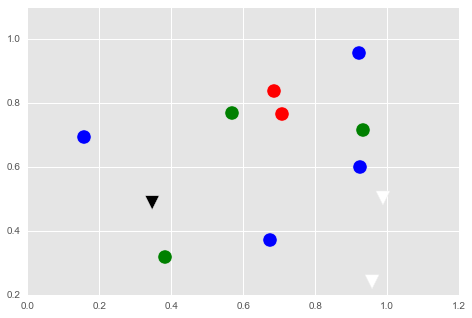

In [221]:
import matplotlib.pyplot as plt

fig = plt.figure(1)
ax = plt.axes([0., 0., 1., 1.])

points = np.random.rand(2,2) # plot 2 points, OK
ax.scatter(points[0], points[1], c=[[1, 0, 0]],  s=200)
points = np.random.rand(2,3) # plot 3 points, broken
ax.scatter(points[0], points[1], marker='v', c=[[0, 1, 0]], s=200)
points = np.random.rand(2,3) # plot 3 points with string color, OK
ax.scatter(points[0], points[1], c='g', s=200)
points = np.random.rand(2,4) # plot 4 points, OK
ax.scatter(points[0], points[1], c=[[0, 0, 1]], s=200)
plt.show()


In [35]:
#print(matplotlib.markers.__doc__)
#dir(matplotlib.markers)
matplotlib.markers.MarkerStyle.markers.keys()

dict_keys([0, 1, 2, '+', 4, 5, 6, '|', '4', '1', 's', 'H', '*', 'x', ' ', '.', 'p', ',', '', 3, '<', '8', 'None', '>', 'D', '3', None, 'h', '_', 'v', 7, 'o', 'd', '2', '^'])